In [4]:
import pandas as pd
import os
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt

In [5]:
DATA_DIR = 'ml-20m/'
movie_emb_f = 'movie_emb_multilingual.pkl'
movie_emb_path = 'ml_dataset/'

# Item embeddings

We will create a sentence out of the tags associated with a movei and use a pre-trained sentence encoder to encoder taht sentence

In [3]:
movies = pd.read_csv(os.path.join(DATA_DIR, 'movies.csv'), header=0)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.describe()

,movieId
count,27278.000000
mean,59855.480570
std,44429.314697
min,1.000000
25%,6931.250000
50%,68068.000000
75%,100293.250000
max,131262.000000


27278 movies, we have title and genre information, titles of movies are very vague and dont give very accuracte represnetation of what that movie will be like or is about, so we will use tags instead.


In [7]:
tags = pd.read_csv(os.path.join(DATA_DIR, 'genome-tags.csv'), header=0)
tags.head(20)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


In [8]:
tags.describe()

,tagId
count,1128.000000
mean,564.500000
std,325.769857
min,1.000000
25%,282.750000
50%,564.500000
75%,846.250000
max,1128.000000


only 1128 tags, so sad 

In [9]:
tag_movie_link = pd.read_csv(os.path.join(DATA_DIR, 'genome-scores.csv'), header=0)
tag_movie_link.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [10]:
tag_movie_link.describe()

,movieId,tagId,relevance
count,1.170977e+07,1.170977e+07,1.170977e+07
mean,2.584297e+04,5.645000e+02,1.164833e-01
std,3.467615e+04,3.256254e+02,1.542463e-01
min,1.000000e+00,1.000000e+00,2.500000e-04
25%,2.926000e+03,2.827500e+02,2.425000e-02
50%,6.017000e+03,5.645000e+02,5.650000e-02
75%,4.606200e+04,8.462500e+02,1.415000e-01
max,1.311700e+05,1.128000e+03,1.000000e+00


<AxesSubplot:>

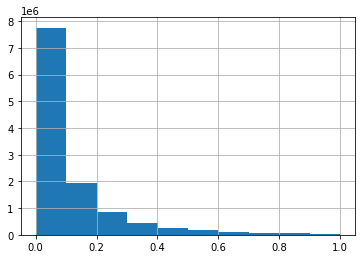

In [11]:
tag_movie_link['relevance'].hist()

In [12]:
only_highly_relevant_tags = tag_movie_link[tag_movie_link['relevance']>=0.5].merge(tags, on='tagId')[['movieId','tag']]
only_highly_relevant_tags

,movieId,tag
0,1,3d
1,33,3d
2,37,3d
3,1389,3d
4,1976,3d
...,...,...
460085,66097,neil gaiman
460086,50798,waste of time
460087,52712,waste of time
460088,82095,waste of time


In [15]:
only_highly_relevant_tags['tag'].value_counts()[:30]

original              10364
mentor                 5044
dialogue               4430
great ending           4356
good soundtrack        3788
good                   3437
story                  3366
great                  3253
storytelling           3130
runaway                2989
criterion              2744
drama                  2733
talky                  2668
brutality              2564
predictable            2549
weird                  2374
cinematography         2340
pornography            2334
pg-13                  2322
social commentary      2321
destiny                2303
melancholic            2295
fun movie              2271
great acting           2219
culture clash          2205
visually appealing     2198
life philosophy        2131
chase                  2105
catastrophe            2060
complex                2053
Name: tag, dtype: int64

In [14]:
from string import punctuation
from nltk import word_tokenize

def preprocess(x):
    y = ' '.join(x)
    stop_words = set(stopwords.words('english') + list(punctuation)+list('and'))
    return ' '.join(set([w for w in word_tokenize(y) if not w.lower() in stop_words]))


In [15]:
movie_tags = only_highly_relevant_tags.groupby('movieId')['tag'].apply(lambda x: preprocess(x)).reset_index()
movie_tags.head()

,movieId,tag
0,1,feel-good animal movie feature storytelling ta...
1,2,comedy runaway adapted animation lions animal ...
2,3,comedy mentor great chase romance silly sequel...
3,4,feel-good stereotypes feel friendships movie o...
4,5,feel-good comedy culture feel movie original d...


We also combine the genres that are associated with the movie and combine it with the tags to create a metadata sentence

In [ ]:
movies = movies.merge(movie_tags, on='movieId', how='left')
movies.head()

In [17]:
movies['tag'] = movies['tag'].fillna('')

In [18]:
movies['genres'] = [i.replace('|', ' ') for i in movies['genres']]
movies['metadata'] = movies['genres'] + ' ' + movies['tag']

In [19]:
movies['metadata'].head()

0    Adventure Animation Children Comedy Fantasy fe...
1    Adventure Children Fantasy comedy runaway adap...
2    Comedy Romance comedy mentor great chase roman...
3    Comedy Drama Romance feel-good stereotypes fee...
4    Comedy feel-good comedy culture feel movie ori...
Name: metadata, dtype: object

In [118]:
# movies['genre_list'] = [i.split('|') for i in movies['genres']]
# genres = movies['genre_list'].apply(pd.Series).stack().unique()

In [138]:
# for genre in genres:
#     movies[genre]=[1.0 if genre in i else 0.0 for i in movies['genre_list']]

In [137]:
# len(np.array(movies[genres])[0])

20

In [21]:
# sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
sbert_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

Downloading: 100%|██████████| 190/190 [00:00<00:00, 44.5kB/s]
Downloading: 100%|██████████| 3.77k/3.77k [00:00<00:00, 802kB/s]
Downloading: 100%|██████████| 229/229 [00:00<00:00, 6.48kB/s]
Downloading: 100%|██████████| 1.11G/1.11G [02:18<00:00, 8.04MB/s]
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 14.7kB/s]
Downloading: 100%|██████████| 5.07M/5.07M [00:00<00:00, 5.77MB/s]
Downloading: 100%|██████████| 239/239 [00:00<00:00, 78.6kB/s]
Downloading: 100%|██████████| 9.08M/9.08M [00:06<00:00, 1.49MB/s]
Downloading: 100%|██████████| 402/402 [00:00<00:00, 63.9kB/s]


In [23]:
meta_data_dict = {}
for i, movie in tqdm(zip(movies['movieId'], movies['metadata'])):
    meta_data_dict[i]=list(sbert_model.encode(movie))

27278it [1:33:20,  4.87it/s]


In [24]:
emb_filpath = movie_emb_path + movie_emb_f
with open(emb_filpath, 'wb') as f:
    pickle.dump(meta_data_dict, f)

In [28]:
with open(emb_filpath, 'rb') as pickle_file:
    emb = pickle.load(pickle_file)

In [29]:
len(emb[1])

768